# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import scipy as sc
import matplotlib.pyplot as plt
import random
import itertools
from inspect import signature
from tqdm import tqdm

In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [44]:
t = np.arange(1024)

In [55]:
def generate_random_signal(function, parameters_grid, t):
    generated_parameters = {}
    for param, values in parameters_grid.items():
        if values == 'float':
            param_value = random.uniform(-1000.0, 1000.0)
        elif values == 'int':
            param_value = random.randint(-1000, 1000)
        elif values[:4] == 'arr(':
            par_str = values[4:-1]
            start, end, *param_lens = list(map(int, par_str.split(',')))
            if len(param_lens) == 1:
                param_len = param_lens[0]
            else:
                param_len = random.randint(param_len[0], param_len[1])
            if param_len != 1:
                param_value = [random.uniform(start, end) for i in range(param_len)]
            else:
                param_value = random.uniform(start, end)
        elif values == 'int+float':
            rand_float = random.uniform(-1000.0, 1000.0)
            rand_int = random.randint(-1000, 1000)
            param_value = random.choice([rand_int, rand_float])
        elif values[:6] == 'float(':
            # range generator
            val_range = values[6:-1]
            val_range = list(map(float, val_range.split(',')))
            param_value = random.uniform(val_range[0], val_range[1])
        elif values[:4] == 'int(':
            val_range = values[4:-1]
            val_range = list(map(int, val_range.split(',')))
            # range generator
            param_value = random.randint(val_range[0], val_range[1])
        else:
            param_value = random.choice(values)
        generated_parameters[param] = param_value
    return function(t, **generated_parameters)

In [68]:
def generate_signals_by_grid(function, parameters_grid, t):
    params_names = list(parameters_grid.keys())
    params_values = []
    for name in params_names:
        params_values.append(parameters_grid[name])
    signals = []
    for param_pair in list(product(*params_values)):
        params = {params_names[i]: param_pair[i] for i in range(len(param_pair))}
        signals.append(function(t, **params))

    return signals

In [456]:
DATASET_FILENAME = 'dataset.csv'

In [107]:
def generate_random_dataset(t, funcs, size, batch_size, filename):
    with open(filename, 'w') as f:
        sig_h = [f'signal_t{i}' for i in range(1024)]
        fur_h = [f'fourier_t{i}' for i in range(1024)]
        f.write(','.join(sig_h + fur_h) + '\n')
    
    for func_name, func in funcs.items():
        batch = []
        for i in range(size):
            gen_sig = generate_random_signal(func['function'], func['params_grid'], t)
            gen_fur = np.fft.fft(gen_sig)
            line = np.concatenate((gen_sig, gen_fur))
            batch.append(line)
            if len(batch) > batch_size:
                batch = np.array(batch)
                with open(filename, 'ab') as csv_file:
                    np.savetxt(csv_file, batch, delimiter=",")
                batch = []

In [131]:
functions_random = {
    'sin': {
        'function': lambda t, scale, var, bias: np.sin(scale * t + var) + bias,
        'params_grid': {'scale': 'float', 'var': 'float', 'bias': 'float'}
    },
    'line': {
        'function': lambda t, a, b: a*t+b,
        'params_grid': {'a': 'float', 'b': 'float'}
    },
    'exp': {
        'function': lambda t, a, b, c, d: c*np.exp(a*t+b)+d,
        'params_grid': {'a': 'float(-50,50)', 'b': 'float(-50,50)', 'c': 'float', 'd': 'float'}
    },
    'log': {
        'function': lambda t, a, b, c, d: c*np.log(np.abs(a * t + b) + 1)+d,
        'params_grid': {'a': 'float', 'b': 'float', 'c': 'float', 'd': 'float'}
    },
    # 'pow': {
    #     'function': lambda t, power, a, b, c, d: c*((a * t + b) ** power)+d,
    #     'params_grid': {'power': 'int+float', 'a': 'float', 'b': 'float', 'c': 'float', 'd': 'float'}
    # },
    'chirp': {
        'function': lambda t, f0, f1, t1, method, phi: signal.chirp(t, f0, f1, t1, method, phi),
        'params_grid': {'f0': 'float', 'f1': 'float', 't1': 'float', 'method': ['linear', 'quadratic'], 'phi': 'float'}
    },
    'gausspulse': {
        'function': lambda t, fc, bw, bwr, tpr: signal.gausspulse(t, fc, bw, bwr, tpr),
        'params_grid': {'fc': 'float(0,1000)', 'bw': 'float(0,1000)', 'bwr': 'float(-200,0)', 'tpr': 'float'}
    },
    'sawtooth': {
        'function': lambda t, width: signal.sawtooth(t, width),
        'params_grid': {'width': 'float(0,1)'}
    },
    'square': {
        'function': lambda t, duty: signal.square(t, duty),
        'params_grid': {'duty': 'float(0,1)'}
    },
    # 'sweep_poly': {
    #     'function': lambda t, poly, phi: signal.sweep_poly(t, poly, phi),
    #     'params_grid': {'poly': 'arr(-100,100,1,10)', 'phi': 'float'}
    # },
    'random_noise': {
        'function': lambda t, mean, var: np.random.normal(mean, var, len(t)),
        'params_grid': {'mean': 'float', 'var': 'float(0,1000)'}
    },
    'unit_impulse': {
        'function': lambda t, idx: signal.unit_impulse(len(t), idx),
        'params_grid': {'idx': 'int'}
    },

}

In [109]:
functions_grid = {
    'sin': {
        'function': lambda t, scale, var, bias: np.sin(scale * t + var) + bias,
        'params_grid': {'scale': [0.25 * (i+1) * np.pi for i in range(20)], 'var': 'float', 'bias': [-10.0 + (i+1) * 0.5 for i in range(40)]}
    },
    'line': {
        'function': lambda t, a, b: a*t+b,
        'params_grid': {'a': [-10.0 + 0.5 * i for i in range(40)], 'b': [-10.0 + 0.5 * i for i in range(40)]}
    },
    'exp': {
        'function': lambda t, a, b, c, d: c*np.exp(a*t+b)+d,
        'params_grid': {'a': [-10.0 + 0.5 * i for i in range(40)], 'b': [-10.0 + 0.5 * i for i in range(40)], 'c': [-10.0 + 0.5 * i for i in range(40)], 'd': [-10.0 + 0.5 * i for i in range(40)]}
    },
    'log': {
        'function': lambda t, a, b, c, d: c*np.log(np.abs(a * t + b) + 1)+d,
        'params_grid': {'a': [-10.0 + 0.5 * i for i in range(40)], 'b': [-10.0 + 0.5 * i for i in range(40)], 'c': [-10.0 + 0.5 * i for i in range(40)], 'd': [-10.0 + 0.5 * i for i in range(40)]}
    },
    'pow': {
        'function': lambda t, pow, a, b, c, d: c*np.pow(a * t + b, pow)+d,
        'params_grid': {'pow': [-10.0 + 0.5 * i for i in range(40)], 'a': [-10.0 + 0.5 * i for i in range(40)], 'b': [-10.0 + 0.5 * i for i in range(40)], 'c': [-10.0 + 0.5 * i for i in range(40)], 'd': [-10.0 + 0.5 * i for i in range(40)]}
    },
}

In [132]:
generate_random_dataset(t, functions_random, 1000, 100, DATASET_FILENAME)

/tmp/ipykernel_4251/2777498442.py:11: RuntimeWarning: overflow encountered in exp
  'function': lambda t, a, b, c, d: c*np.exp(a*t+b)+d,
/tmp/ipykernel_4251/2777498442.py:11: RuntimeWarning: overflow encountered in multiply
  'function': lambda t, a, b, c, d: c*np.exp(a*t+b)+d,


In [457]:
data = pd.read_csv(DATASET_FILENAME, sep=",")
data = data.apply(lambda col: col.apply(lambda val: complex(val.strip())))

In [458]:
data.iloc[:, 1024:].to_numpy().dtype

dtype('complex128')

In [459]:
nans = data.isna().any(axis=1)
nans_i = nans[nans == True].index.tolist()
data = data.drop(nans_i)

In [460]:
X_data = data.iloc[:, :1024].to_numpy()
X_data = torch.tensor(X_data, dtype=torch.cfloat)
y_data = data.iloc[:, 1024:].to_numpy()
y_data = torch.tensor(y_data, dtype=torch.cfloat)
index_y_inf = list(data.index[torch.isinf(y_data).any(axis=1)])
index_x_inf = list(data.index[torch.isinf(X_data).any(axis=1)])
data = data.drop(index_y_inf + index_x_inf)
data.info

<bound method DataFrame.info of                    signal_t0               signal_t1               signal_t2  \
0    -112.149918+  0.000000j -110.572777+  0.000000j -110.691586+  0.000000j   
1    -471.265283+  0.000000j -472.269707+  0.000000j -472.736682+  0.000000j   
2      34.158157+  0.000000j   32.762265+  0.000000j   33.173215+  0.000000j   
3    -994.948626+  0.000000j -993.728142+  0.000000j -993.659511+  0.000000j   
4    -245.704623+  0.000000j -247.078292+  0.000000j -247.380916+  0.000000j   
...                      ...                     ...                     ...   
9085    0.000000+  0.000000j    0.000000+  0.000000j    0.000000+  0.000000j   
9086    0.000000+  0.000000j    0.000000+  0.000000j    0.000000+  0.000000j   
9087    0.000000+  0.000000j    0.000000+  0.000000j    0.000000+  0.000000j   
9088    0.000000+  0.000000j    0.000000+  0.000000j    0.000000+  0.000000j   
9089    0.000000+  0.000000j    0.000000+  0.000000j    0.000000+  0.000000j   

       

In [461]:
X_data = data.iloc[:, :1024].to_numpy()
X_data = torch.tensor(X_data, dtype=torch.cfloat)

In [462]:
y_data = data.iloc[:, 1024:].to_numpy()
y_data = torch.tensor(y_data, dtype=torch.cfloat)

In [463]:
indexNum = data.index[torch.isinf(complex_decoder(X_train)).any(axis=1)]
indexNum

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8651 but corresponding boolean dimension is 7785

In [483]:
X_train.size()

torch.Size([9000, 1024])

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42, shuffle=True)

In [4]:
N = 1024
batch = 90000

# Generate random input data and desired output data
sig = np.random.randn(batch, N) + 1j*np.random.randn(batch, N)
F = np.fft.fft(sig, axis=-1)

# First half of inputs/outputs is real part, second half is imaginary part
X = torch.tensor(sig, dtype=torch.complex64)
Y = torch.tensor(F, dtype=torch.complex64)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle=True)

device = torch.device('cuda')
X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)

tensor([[ -9.3411-20.0321j,   3.4986-45.8826j,   6.4725-30.7130j,
          ...,  11.0664+14.0327j,  33.4909+43.9174j,
         -63.2263+20.7808j],
        [ 62.0126+15.2864j, -10.4740-32.4978j,  19.5741-30.8643j,
          ..., -10.3562-6.3665j,  -3.6249+8.3454j,
         -56.2355-25.8026j],
        [ -3.5923+16.2104j,  10.0127-14.9041j, -49.7492-0.7962j,
          ..., -57.3756+40.8329j,  10.0849+58.5082j,
          14.8747-47.4842j],
        ...,
        [ 27.0903+23.4804j,  38.2056+22.5469j, -33.1531+56.3263j,
          ...,  34.1725+4.0035j, -14.3796-40.8444j,
         -11.5531-7.0967j],
        [-59.4887+25.8921j, -11.5128+50.8854j,  52.0028+45.1559j,
          ..., -35.9350+33.3836j,  30.3495+32.5593j,
          29.2627+54.7003j],
        [ 13.7873-34.1962j,   1.0726-4.4293j,  23.6184-58.6047j,
          ...,  11.1006-13.7084j,  10.0098-59.6270j,
         -28.7355-29.1670j]], device='cuda:0')

### Соберите и обучите нейросетку на pyTroch для преобразования Фурье

Обернем в функцию

Внешние части - декодер и энкодер комплексного вектора размера N в вещественный вектор размера 2*N - просто нужно в первом случае засплитить, во втором - сложить две матрицы _real_, _im_ как _real + j * im_

Внутренняя часть - нейронка

In [79]:
def complex_decoder(A):
    real = A.real
    imag = A.imag
    if type(A).__name__ == 'Tensor':
        if A.dim() == 1:
            ax = 0
        else:
            ax = 1
        return torch.cat((real, imag), ax)
    elif type(A).__name__ == 'ndarray':
        if A.ndim == 1:
            ax = 0
        else:
            ax = 1
        return np.concatenate((real, imag), ax)

def complex_encoder(real, imag=None, dtype='Tensor'):
    if imag is None:
        if type(real).__name__ == 'ndarray':
            dim = real.ndim
            half = int(real.shape[dim-1] / 2)
        else:
            dim = real.dim()
            half = int(real.size(dim-1) / 2)
        if dim == 2:
            imag = real[:, half:]
            real = real[:, :half]
        else:
            imag = real[half:]
            real = real[:half]
    
    if type(real).__name__ == 'ndarray':
        real = torch.Tensor(real)
    if type(imag).__name__ == 'ndarray':
        real = torch.Tensor(imag)
    if dtype == 'Tensor':
        return torch.complex(real, imag)
    else:
        return torch.complex(real, imag).numpy()

In [144]:
D_in = 2048
D_out = 2048

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 2 * D_in),
    torch.nn.BatchNorm1d(2 * D_in),
    torch.nn.ReLU(),
    # torch.nn.Dropout(0.2),
    torch.nn.Linear(2 * D_in, D_out),
    # torch.nn.BatchNorm1d(D_out),
    # torch.nn.ReLU(),
    # torch.nn.Linear(D_out, D_out),
)

In [145]:
def custom_fft(X, model):
    if type(X).__name__ == 'ndarray':
        A = torch.tensor(X.copy(), dtype=torch.complex64)
    else:
        A = X.copy()
    decoded = complex_decoder(A)
    dim = decoded.ndim
    if dim == 1:
        decoded = decoded.view(1, decoded.size(0)) 
    model.eval()
    fft_decoded = model(torch.atleast_2d(decoded))
    answer = complex_encoder(fft_decoded)
    if type(X).__name__ == 'ndarray':
        ans = answer.detach().numpy()
    else:
        ans = answer.detach()

    if dim == 1:
        return ans[0]
    else:
        return ans

In [191]:
def batch_train(model, loss_fn, optimizer, x, y):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item())
    
def train(model, n_epochs, batch_size, loss_fn, optimizer, X, y, X_test, y_test, scheduler = None, lr_decay: int = None):
    mse_train_all = []
    loss_train_all = []
    mse_test_all = []
    loss_test_all = []

    if lr_decay is not None:
        decay_epochs = [int(n_epochs / lr_decay) * (i+1) for i in range(lr_decay)]    
        print(f'Learning rate Decays will be at epochs: {decay_epochs}')
    
    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        if lr_decay is not None:
            if epoch in decay_epochs:
                print(f'\nLearning rate Decay')
                for i in range(len(optimizer.param_groups)):
                    optimizer.param_groups[i]['lr'] /= 5

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, loss_fn, optimizer, batch_x, batch_y)

        if scheduler is not None:
            scheduler.step()
        
        y_test_pred = model(X_test)
        y_train_pred = model(X)


        mse_train = mean_squared_error(y.detach().numpy(), y_train_pred.detach().numpy())
        loss_train = loss_fn(y_train_pred, y).detach()
        mse_test = mean_squared_error(y_test.detach().numpy(), y_test_pred.detach().numpy())
        loss_test = loss_fn(y_test_pred, y_test).detach()

        mse_train_all = np.append(mse_train_all, mse_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        mse_test_all = np.append(mse_test_all, mse_test)
        loss_test_all = np.append(loss_test_all, loss_test)


        print(f'Epoch {epoch}: \n MSE score - train: {mse_train} | test: {mse_test} \n Loss - train: {loss_train} | test: {loss_test}')

    return(mse_train_all, loss_train_all, mse_test_all, loss_test_all)

In [147]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [148]:
def vis_history(mse_train_all, loss_train_all, mse_test_all, loss_test_all):
    fig = plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)

    plt.plot(loss_train_all, label='loss')
    plt.plot(loss_test_all, label='val_loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mse_train_all, label='mse')
    plt.plot(mse_test_all, label='val_mse')

    plt.legend()
    plt.show()

In [149]:
n_epochs = 100
batch_size = 1000
learning_rate = 1e-3
lr_decay = 3

In [151]:
optimizerAdam = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizerAdam, milestones=[int(n_epochs / lr_decay) * (i+1) for i in range(lr_decay)], gamma=0.5)
model = model.apply(init_weights)
loss_fn = torch.nn.MSELoss()

In [152]:
complex_decoder(X_train).size()

torch.Size([81000, 2048])

In [153]:
y_train

tensor([[-12.5215-3.0965j,  -2.7678+30.9647j,  12.4281+24.8964j,
          ...,   5.0958+12.5735j,  75.8720-64.2397j,
          21.7590-13.5567j],
        [  0.6113-4.1439j,  76.3918-32.5898j,  35.8335+7.7877j,
          ..., -39.1238+87.1407j, -24.9280-23.9952j,
          84.6249+57.6212j],
        [-18.6259-32.3636j,   3.9433+4.9052j,   9.7154-47.2077j,
          ..., -26.4290-31.4086j, -12.3765-5.4546j,
          50.4817+18.9686j],
        ...,
        [  4.4139+27.8784j,  12.6473-29.9207j, -35.7743-10.0633j,
          ...,  -2.1150+10.1666j,  34.1627-1.5806j,
         -45.5443-17.7019j],
        [ 25.8896-7.4039j,  11.8296+21.8294j,   9.6689-27.1695j,
          ...,   5.4260+18.1836j,  52.2702-31.4362j,
         -26.2822+69.4859j],
        [ 17.4486+51.3993j,  20.2123+75.1453j, -32.2107+37.3918j,
          ...,  17.0842-2.3624j, -34.4356+7.0420j,
          30.4243-20.7109j]])

In [154]:
mse_train_all, loss_train_all, mse_test_all, loss_test_all = \
          train(
              model, n_epochs, batch_size, loss_fn, 
              optimizerAdam, complex_decoder(X_train), complex_decoder(y_train), 
              complex_decoder(X_test), complex_decoder(y_test), scheduler = None
          )

100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.69it/s]


Epoch 0: 
 MSE score - train: 883.5001831054688 | test: 888.0187377929688 
 Loss - train: 883.5099487304688 | test: 888.01904296875


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.73it/s]


Epoch 1: 
 MSE score - train: 748.0313110351562 | test: 761.1575317382812 
 Loss - train: 748.0391845703125 | test: 761.1578979492188


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.73it/s]


Epoch 2: 
 MSE score - train: 605.349365234375 | test: 626.7958984375 
 Loss - train: 605.3567504882812 | test: 626.796142578125


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.67it/s]


Epoch 3: 
 MSE score - train: 469.22796630859375 | test: 496.5523681640625 
 Loss - train: 469.2334289550781 | test: 496.552490234375


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 4: 
 MSE score - train: 350.4190673828125 | test: 380.51910400390625 
 Loss - train: 350.4229736328125 | test: 380.519287109375


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 5: 
 MSE score - train: 254.67869567871094 | test: 285.08740234375 
 Loss - train: 254.68173217773438 | test: 285.08758544921875


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.62it/s]


Epoch 6: 
 MSE score - train: 183.84085083007812 | test: 212.89561462402344 
 Loss - train: 183.84283447265625 | test: 212.8957061767578


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.62it/s]


Epoch 7: 
 MSE score - train: 135.39913940429688 | test: 162.40841674804688 
 Loss - train: 135.40081787109375 | test: 162.40850830078125


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.63it/s]


Epoch 8: 
 MSE score - train: 104.58770751953125 | test: 129.51626586914062 
 Loss - train: 104.58879089355469 | test: 129.51632690429688


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 9: 
 MSE score - train: 85.86429595947266 | test: 108.94766998291016 
 Loss - train: 85.86528778076172 | test: 108.94770050048828


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 10: 
 MSE score - train: 74.8115005493164 | test: 96.47694396972656 
 Loss - train: 74.81241607666016 | test: 96.47698211669922


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 11: 
 MSE score - train: 67.52989196777344 | test: 88.20830535888672 
 Loss - train: 67.53072357177734 | test: 88.20834350585938


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 12: 
 MSE score - train: 62.641517639160156 | test: 82.60212707519531 
 Loss - train: 62.642276763916016 | test: 82.60215759277344


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 13: 
 MSE score - train: 58.98088073730469 | test: 78.50901794433594 
 Loss - train: 58.98157501220703 | test: 78.5090560913086


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 14: 
 MSE score - train: 55.71665954589844 | test: 74.83980560302734 
 Loss - train: 55.71727752685547 | test: 74.83984375


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.60it/s]


Epoch 15: 
 MSE score - train: 53.139381408691406 | test: 71.96065521240234 
 Loss - train: 53.13993835449219 | test: 71.96068572998047


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 16: 
 MSE score - train: 50.56587219238281 | test: 69.13690948486328 
 Loss - train: 50.56640625 | test: 69.1369400024414


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.70it/s]


Epoch 17: 
 MSE score - train: 48.15278244018555 | test: 66.38773345947266 
 Loss - train: 48.153297424316406 | test: 66.38775634765625


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 18: 
 MSE score - train: 45.849884033203125 | test: 63.801815032958984 
 Loss - train: 45.85038375854492 | test: 63.801841735839844


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 19: 
 MSE score - train: 43.5752067565918 | test: 61.204898834228516 
 Loss - train: 43.57569885253906 | test: 61.204917907714844


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.59it/s]


Epoch 20: 
 MSE score - train: 41.42060852050781 | test: 58.75246810913086 
 Loss - train: 41.42108154296875 | test: 58.75248718261719


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch 21: 
 MSE score - train: 39.38857650756836 | test: 56.361087799072266 
 Loss - train: 39.389041900634766 | test: 56.36110305786133


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.67it/s]


Epoch 22: 
 MSE score - train: 37.188011169433594 | test: 53.78206253051758 
 Loss - train: 37.18845748901367 | test: 53.782081604003906


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 23: 
 MSE score - train: 35.416683197021484 | test: 51.722084045410156 
 Loss - train: 35.4171142578125 | test: 51.722103118896484


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.67it/s]


Epoch 24: 
 MSE score - train: 33.60832977294922 | test: 49.4471435546875 
 Loss - train: 33.60873794555664 | test: 49.44716262817383


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.70it/s]


Epoch 25: 
 MSE score - train: 31.769302368164062 | test: 47.2700080871582 
 Loss - train: 31.76968765258789 | test: 47.27002716064453


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.69it/s]


Epoch 26: 
 MSE score - train: 29.991573333740234 | test: 45.11885070800781 
 Loss - train: 29.99191665649414 | test: 45.118873596191406


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 27: 
 MSE score - train: 28.344131469726562 | test: 43.07991027832031 
 Loss - train: 28.344444274902344 | test: 43.079933166503906


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.62it/s]


Epoch 28: 
 MSE score - train: 26.97966957092285 | test: 41.353912353515625 
 Loss - train: 26.979957580566406 | test: 41.35393142700195


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 29: 
 MSE score - train: 25.595468521118164 | test: 39.59569549560547 
 Loss - train: 25.595746994018555 | test: 39.59571075439453


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.69it/s]


Epoch 30: 
 MSE score - train: 24.259599685668945 | test: 37.87983703613281 
 Loss - train: 24.25986099243164 | test: 37.879859924316406


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 31: 
 MSE score - train: 22.886871337890625 | test: 36.157447814941406 
 Loss - train: 22.887126922607422 | test: 36.15746307373047


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch 32: 
 MSE score - train: 21.576501846313477 | test: 34.512107849121094 
 Loss - train: 21.576749801635742 | test: 34.512123107910156


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.70it/s]


Epoch 33: 
 MSE score - train: 20.591495513916016 | test: 33.162200927734375 
 Loss - train: 20.59172821044922 | test: 33.16221618652344


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.69it/s]


Epoch 34: 
 MSE score - train: 19.570987701416016 | test: 31.88155746459961 
 Loss - train: 19.571216583251953 | test: 31.881572723388672


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch 35: 
 MSE score - train: 18.610546112060547 | test: 30.559446334838867 
 Loss - train: 18.610761642456055 | test: 30.5594539642334


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 36: 
 MSE score - train: 17.646684646606445 | test: 29.32676124572754 
 Loss - train: 17.646892547607422 | test: 29.326766967773438


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.68it/s]


Epoch 37: 
 MSE score - train: 16.768272399902344 | test: 28.1624755859375 
 Loss - train: 16.768465042114258 | test: 28.162487030029297


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 38: 
 MSE score - train: 16.26272201538086 | test: 27.401927947998047 
 Loss - train: 16.26290512084961 | test: 27.401941299438477


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.65it/s]


Epoch 39: 
 MSE score - train: 15.360513687133789 | test: 26.186689376831055 
 Loss - train: 15.36068058013916 | test: 26.186702728271484


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.71it/s]


Epoch 40: 
 MSE score - train: 14.780611038208008 | test: 25.43201446533203 
 Loss - train: 14.780770301818848 | test: 25.432025909423828


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.69it/s]


Epoch 41: 
 MSE score - train: 14.038334846496582 | test: 24.484970092773438 
 Loss - train: 14.038482666015625 | test: 24.484981536865234


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.59it/s]


Epoch 42: 
 MSE score - train: 13.61353588104248 | test: 23.797931671142578 
 Loss - train: 13.61368179321289 | test: 23.797941207885742


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.62it/s]


Epoch 43: 
 MSE score - train: 13.024124145507812 | test: 23.01181411743164 
 Loss - train: 13.024264335632324 | test: 23.011823654174805


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.72it/s]


Epoch 44: 
 MSE score - train: 12.511542320251465 | test: 22.341665267944336 
 Loss - train: 12.511677742004395 | test: 22.341672897338867


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.75it/s]


Epoch 45: 
 MSE score - train: 12.189131736755371 | test: 21.857887268066406 
 Loss - train: 12.189263343811035 | test: 21.85789680480957


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.62it/s]


Epoch 46: 
 MSE score - train: 11.712844848632812 | test: 21.201190948486328 
 Loss - train: 11.712972640991211 | test: 21.201196670532227


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch 47: 
 MSE score - train: 11.509889602661133 | test: 20.827417373657227 
 Loss - train: 11.510013580322266 | test: 20.827423095703125


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.66it/s]


Epoch 48: 
 MSE score - train: 11.058277130126953 | test: 20.15497589111328 
 Loss - train: 11.05840015411377 | test: 20.154983520507812


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 49: 
 MSE score - train: 10.64346694946289 | test: 19.587188720703125 
 Loss - train: 10.643583297729492 | test: 19.587194442749023


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.57it/s]


Epoch 50: 
 MSE score - train: 10.321043014526367 | test: 19.11403465270996 
 Loss - train: 10.321152687072754 | test: 19.114044189453125


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.61it/s]


Epoch 51: 
 MSE score - train: 9.959335327148438 | test: 18.66677474975586 
 Loss - train: 9.959440231323242 | test: 18.666778564453125


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.64it/s]


Epoch 52: 
 MSE score - train: 9.90433120727539 | test: 18.416118621826172 
 Loss - train: 9.904435157775879 | test: 18.416126251220703


100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.59it/s]


Epoch 53: 
 MSE score - train: 9.367548942565918 | test: 17.803424835205078 
 Loss - train: 9.367646217346191 | test: 17.80343246459961


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 54: 
 MSE score - train: 9.228048324584961 | test: 17.512428283691406 
 Loss - train: 9.228140830993652 | test: 17.512434005737305


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 55: 
 MSE score - train: 8.84758186340332 | test: 17.037227630615234 
 Loss - train: 8.847670555114746 | test: 17.037233352661133


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 56: 
 MSE score - train: 8.788694381713867 | test: 16.87140655517578 
 Loss - train: 8.788780212402344 | test: 16.87141227722168


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.23it/s]


Epoch 57: 
 MSE score - train: 8.628795623779297 | test: 16.607196807861328 
 Loss - train: 8.628876686096191 | test: 16.607200622558594


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.33it/s]


Epoch 58: 
 MSE score - train: 8.390083312988281 | test: 16.29938507080078 
 Loss - train: 8.390165328979492 | test: 16.299392700195312


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.17it/s]


Epoch 59: 
 MSE score - train: 8.24311637878418 | test: 16.047931671142578 
 Loss - train: 8.243196487426758 | test: 16.047937393188477


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.15it/s]


Epoch 60: 
 MSE score - train: 8.204927444458008 | test: 15.930534362792969 
 Loss - train: 8.20500373840332 | test: 15.930540084838867


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.10it/s]


Epoch 61: 
 MSE score - train: 7.877392768859863 | test: 15.541200637817383 
 Loss - train: 7.877469062805176 | test: 15.541208267211914


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.14it/s]


Epoch 62: 
 MSE score - train: 7.729013442993164 | test: 15.283685684204102 
 Loss - train: 7.72908878326416 | test: 15.28369140625


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.15it/s]


Epoch 63: 
 MSE score - train: 7.700845718383789 | test: 15.189701080322266 
 Loss - train: 7.700918197631836 | test: 15.189706802368164


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.08it/s]


Epoch 64: 
 MSE score - train: 7.614605903625488 | test: 14.980792999267578 
 Loss - train: 7.614676475524902 | test: 14.980798721313477


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.11it/s]


Epoch 65: 
 MSE score - train: 7.401576995849609 | test: 14.720232009887695 
 Loss - train: 7.401646614074707 | test: 14.720235824584961


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.13it/s]


Epoch 66: 
 MSE score - train: 7.3000640869140625 | test: 14.489713668823242 
 Loss - train: 7.300132751464844 | test: 14.489720344543457


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.18it/s]


Epoch 67: 
 MSE score - train: 7.105499744415283 | test: 14.298868179321289 
 Loss - train: 7.105565547943115 | test: 14.298873901367188


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.26it/s]


Epoch 68: 
 MSE score - train: 6.92174768447876 | test: 14.060906410217285 
 Loss - train: 6.921811580657959 | test: 14.060911178588867


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.33it/s]


Epoch 69: 
 MSE score - train: 6.8515825271606445 | test: 13.941045761108398 
 Loss - train: 6.8516459465026855 | test: 13.941052436828613


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.08it/s]


Epoch 70: 
 MSE score - train: 6.775853633880615 | test: 13.778196334838867 
 Loss - train: 6.775914192199707 | test: 13.77820110321045


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.09it/s]


Epoch 71: 
 MSE score - train: 6.696999549865723 | test: 13.64004135131836 
 Loss - train: 6.69705867767334 | test: 13.640045166015625


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.24it/s]


Epoch 72: 
 MSE score - train: 6.592698097229004 | test: 13.451509475708008 
 Loss - train: 6.592757701873779 | test: 13.451515197753906


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 73: 
 MSE score - train: 6.5847320556640625 | test: 13.381231307983398 
 Loss - train: 6.584790229797363 | test: 13.381237983703613


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.29it/s]


Epoch 74: 
 MSE score - train: 6.475320816040039 | test: 13.243509292602539 
 Loss - train: 6.475376605987549 | test: 13.243515014648438


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.24it/s]


Epoch 75: 
 MSE score - train: 6.382134914398193 | test: 13.063430786132812 
 Loss - train: 6.38218879699707 | test: 13.063434600830078


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 76: 
 MSE score - train: 6.265542030334473 | test: 12.885473251342773 
 Loss - train: 6.26559591293335 | test: 12.885479927062988


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.21it/s]


Epoch 77: 
 MSE score - train: 6.099504470825195 | test: 12.683233261108398 
 Loss - train: 6.099555492401123 | test: 12.683238983154297


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 78: 
 MSE score - train: 6.042510032653809 | test: 12.656274795532227 
 Loss - train: 6.0425591468811035 | test: 12.656279563903809


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.32it/s]


Epoch 79: 
 MSE score - train: 5.980190277099609 | test: 12.476574897766113 
 Loss - train: 5.980238914489746 | test: 12.476579666137695


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 80: 
 MSE score - train: 5.974456787109375 | test: 12.457679748535156 
 Loss - train: 5.974503993988037 | test: 12.457683563232422


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.23it/s]


Epoch 81: 
 MSE score - train: 6.000174522399902 | test: 12.45206356048584 
 Loss - train: 6.000222206115723 | test: 12.452069282531738


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.24it/s]


Epoch 82: 
 MSE score - train: 5.916264057159424 | test: 12.256146430969238 
 Loss - train: 5.9163103103637695 | test: 12.25615119934082


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.30it/s]


Epoch 83: 
 MSE score - train: 5.84654426574707 | test: 12.171329498291016 
 Loss - train: 5.846588134765625 | test: 12.171333312988281


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 84: 
 MSE score - train: 5.548768997192383 | test: 11.856100082397461 
 Loss - train: 5.5488128662109375 | test: 11.856103897094727


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 85: 
 MSE score - train: 5.629934787750244 | test: 11.92220687866211 
 Loss - train: 5.629977226257324 | test: 11.922212600708008


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.24it/s]


Epoch 86: 
 MSE score - train: 5.797453880310059 | test: 12.035021781921387 
 Loss - train: 5.797493934631348 | test: 12.035028457641602


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 87: 
 MSE score - train: 5.701852798461914 | test: 11.901641845703125 
 Loss - train: 5.7018938064575195 | test: 11.901646614074707


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 88: 
 MSE score - train: 5.604437828063965 | test: 11.774930953979492 
 Loss - train: 5.604477405548096 | test: 11.774935722351074


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 89: 
 MSE score - train: 5.462495803833008 | test: 11.626407623291016 
 Loss - train: 5.462536811828613 | test: 11.626413345336914


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 90: 
 MSE score - train: 5.400944709777832 | test: 11.446630477905273 
 Loss - train: 5.40098237991333 | test: 11.446636199951172


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s]


Epoch 91: 
 MSE score - train: 5.455623626708984 | test: 11.524269104003906 
 Loss - train: 5.455662250518799 | test: 11.524273872375488


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 92: 
 MSE score - train: 5.2396135330200195 | test: 11.257641792297363 
 Loss - train: 5.239650249481201 | test: 11.257648468017578


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.20it/s]


Epoch 93: 
 MSE score - train: 5.193427085876465 | test: 11.208646774291992 
 Loss - train: 5.193464279174805 | test: 11.20865249633789


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.27it/s]


Epoch 94: 
 MSE score - train: 5.23386812210083 | test: 11.208673477172852 
 Loss - train: 5.23390531539917 | test: 11.208678245544434


100%|███████████████████████████████████████████| 81/81 [00:18<00:00,  4.26it/s]


Epoch 95: 
 MSE score - train: 5.334355354309082 | test: 11.215105056762695 
 Loss - train: 5.3343915939331055 | test: 11.215109825134277


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 96: 
 MSE score - train: 5.33282470703125 | test: 11.21854019165039 
 Loss - train: 5.332859516143799 | test: 11.21854305267334


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.22it/s]


Epoch 97: 
 MSE score - train: 5.245593547821045 | test: 11.097877502441406 
 Loss - train: 5.2456278800964355 | test: 11.097882270812988


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.26it/s]


Epoch 98: 
 MSE score - train: 5.106705188751221 | test: 10.977459907531738 
 Loss - train: 5.106739521026611 | test: 10.977463722229004


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.25it/s]


Epoch 99: 
 MSE score - train: 4.998683929443359 | test: 10.880352020263672 
 Loss - train: 4.998717784881592 | test: 10.880356788635254


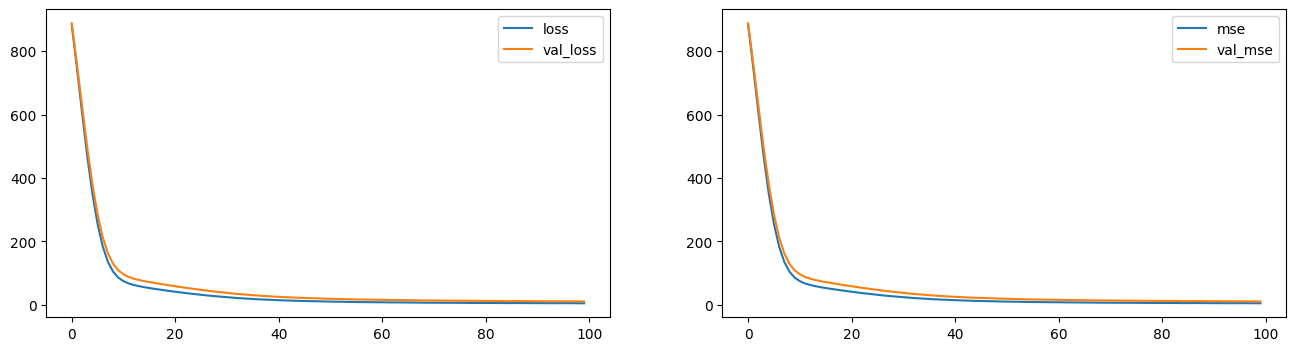

In [155]:
vis_history(mse_train_all, loss_train_all, mse_test_all, loss_test_all)

### Сравните свое решение с пакетным методом

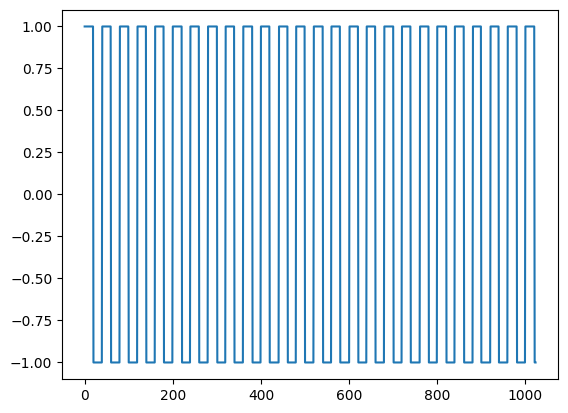

In [156]:
signal_1 = np.sin(t)
signal_2 = signal.square(0.05 * np.pi * t)
plt.plot(t, signal_2)
plt.show()

In [157]:
signal_2.imag

array([0., 0., 0., ..., 0., 0., 0.])

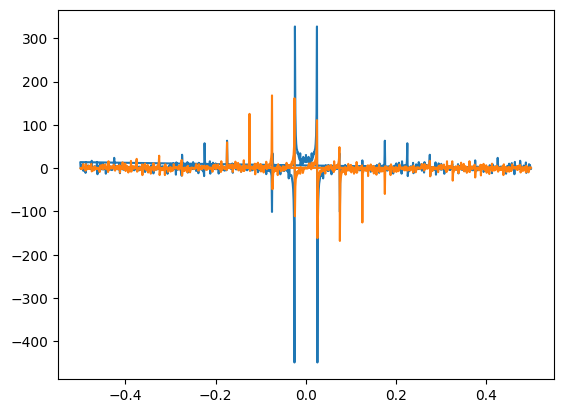

In [158]:
sp = np.fft.fft(signal_2)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

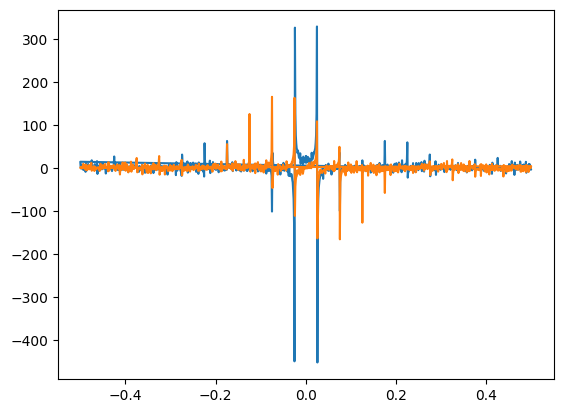

In [160]:
sp_c = custom_fft(signal_2, model)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp_c.real, freq, sp_c.imag)
plt.show()

In [210]:
mean_squared_error(sp.real, sp_c.real)

0.0

In [211]:
mean_squared_error(sp.imag, sp_c.imag)

0.0

## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [183]:
N = 1024
batch = 90000

# Generate random input data and desired output data
sig = np.random.randn(batch, N) #+ 1j*np.random.randn(batch, N)
F = signal.periodogram(sig)[1]

# First half of inputs/outputs is real part, second half is imaginary part
X = torch.tensor(sig, dtype=torch.float32)
Y = torch.tensor(F, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle=True)

device = torch.device('cuda')
X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)


tensor([[4.9304e-32, 2.8713e+00, 3.0012e-01,  ..., 4.4911e-01, 2.9676e+00,
         1.2750e+00],
        [1.9722e-31, 2.1659e-01, 2.7687e+00,  ..., 8.7521e-01, 1.4379e+00,
         3.3465e+00],
        [6.0397e-31, 1.3017e+00, 2.5059e+00,  ..., 1.5329e+00, 2.5905e-01,
         1.0686e+00],
        ...,
        [1.1093e-31, 4.8504e-02, 6.3896e+00,  ..., 2.6779e+00, 1.6914e+00,
         2.4326e-01],
        [3.7286e-31, 4.1924e+00, 3.4027e+00,  ..., 2.6359e+00, 9.4867e-01,
         1.1464e-02],
        [7.8886e-31, 1.7820e+00, 5.4931e+00,  ..., 1.4706e+00, 1.6488e+00,
         4.6347e+00]], device='cuda:0')

In [184]:
X.size()

torch.Size([90000, 1024])

In [185]:
Y.size()

torch.Size([90000, 513])

### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

In [187]:
D_in = 1024
D_out = 513

model_p = torch.nn.Sequential(
    torch.nn.Linear(D_in, 2 * D_in),
    torch.nn.BatchNorm1d(2 * D_in),
    torch.nn.ReLU(),
    # torch.nn.Dropout(0.2),
    torch.nn.Linear(2 * D_in, D_out),
    # torch.nn.BatchNorm1d(D_out),
    # torch.nn.ReLU(),
    # torch.nn.Linear(D_out, D_out),
)

In [188]:
optimizerAdam_p = torch.optim.Adam(model_p.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizerAdam_p, milestones=[int(n_epochs / lr_decay) * (i+1) for i in range(lr_decay)], gamma=0.5)
model_p = model_p.apply(init_weights)
loss_fn = torch.nn.MSELoss()

In [192]:
mse_train_all, loss_train_all, mse_test_all, loss_test_all = \
          train(
              model_p, n_epochs, batch_size, loss_fn, 
              optimizerAdam_p, X_train, y_train, X_test, y_test, scheduler = None, lr_decay=3
          )

Learning rate Decays will be at epochs: [33, 66, 99]


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 25.78it/s]


Epoch 0: 
 MSE score - train: 3.564756393432617 | test: 4.1879987716674805 
 Loss - train: 3.5647976398468018 | test: 4.188000202178955


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.89it/s]


Epoch 1: 
 MSE score - train: 3.549133777618408 | test: 4.197495937347412 
 Loss - train: 3.5491738319396973 | test: 4.197497367858887


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.63it/s]


Epoch 2: 
 MSE score - train: 3.5327625274658203 | test: 4.204074382781982 
 Loss - train: 3.532804012298584 | test: 4.204076290130615


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.62it/s]


Epoch 3: 
 MSE score - train: 3.516171932220459 | test: 4.209571838378906 
 Loss - train: 3.516211986541748 | test: 4.209573268890381


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.43it/s]


Epoch 4: 
 MSE score - train: 3.4985227584838867 | test: 4.211935997009277 
 Loss - train: 3.498562812805176 | test: 4.211938381195068


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.52it/s]


Epoch 5: 
 MSE score - train: 3.4802441596984863 | test: 4.210787296295166 
 Loss - train: 3.4802844524383545 | test: 4.210789203643799


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.59it/s]


Epoch 6: 
 MSE score - train: 3.460700035095215 | test: 4.205982208251953 
 Loss - train: 3.4607391357421875 | test: 4.205984592437744


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.59it/s]


Epoch 7: 
 MSE score - train: 3.4363627433776855 | test: 4.194469451904297 
 Loss - train: 3.436403274536133 | test: 4.194471836090088


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.35it/s]


Epoch 8: 
 MSE score - train: 3.408278703689575 | test: 4.177202224731445 
 Loss - train: 3.4083173274993896 | test: 4.177204132080078


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.77it/s]


Epoch 9: 
 MSE score - train: 3.3783390522003174 | test: 4.153700351715088 
 Loss - train: 3.378377676010132 | test: 4.153702735900879


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.51it/s]


Epoch 10: 
 MSE score - train: 3.3440558910369873 | test: 4.123964786529541 
 Loss - train: 3.3440942764282227 | test: 4.123966693878174


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.18it/s]


Epoch 11: 
 MSE score - train: 3.308243989944458 | test: 4.090172290802002 
 Loss - train: 3.308281660079956 | test: 4.090174674987793


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.39it/s]


Epoch 12: 
 MSE score - train: 3.268150806427002 | test: 4.048813819885254 
 Loss - train: 3.268188953399658 | test: 4.048815727233887


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.45it/s]


Epoch 13: 
 MSE score - train: 3.2223687171936035 | test: 3.9987902641296387 
 Loss - train: 3.2224066257476807 | test: 3.9987919330596924


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.55it/s]


Epoch 14: 
 MSE score - train: 3.173099994659424 | test: 3.94219970703125 
 Loss - train: 3.17313551902771 | test: 3.9422013759613037


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.60it/s]


Epoch 15: 
 MSE score - train: 3.117417812347412 | test: 3.8764994144439697 
 Loss - train: 3.11745548248291 | test: 3.8765008449554443


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.49it/s]


Epoch 16: 
 MSE score - train: 3.0590479373931885 | test: 3.8064489364624023 
 Loss - train: 3.059084415435791 | test: 3.806450843811035


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.24it/s]


Epoch 17: 
 MSE score - train: 2.9965691566467285 | test: 3.7302491664886475 
 Loss - train: 2.9966042041778564 | test: 3.7302513122558594


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.50it/s]


Epoch 18: 
 MSE score - train: 2.930736541748047 | test: 3.648301362991333 
 Loss - train: 2.930772304534912 | test: 3.648303270339966


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.32it/s]


Epoch 19: 
 MSE score - train: 2.8622305393218994 | test: 3.563234329223633 
 Loss - train: 2.862265110015869 | test: 3.5632359981536865


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.04it/s]


Epoch 20: 
 MSE score - train: 2.7934842109680176 | test: 3.4760704040527344 
 Loss - train: 2.7935166358947754 | test: 3.476071834564209


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.07it/s]


Epoch 21: 
 MSE score - train: 2.7220518589019775 | test: 3.3857717514038086 
 Loss - train: 2.7220852375030518 | test: 3.385772943496704


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.79it/s]


Epoch 22: 
 MSE score - train: 2.6503396034240723 | test: 3.294501304626465 
 Loss - train: 2.6503725051879883 | test: 3.2945032119750977


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.24it/s]


Epoch 23: 
 MSE score - train: 2.576697826385498 | test: 3.2003238201141357 
 Loss - train: 2.5767288208007812 | test: 3.200324773788452


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.87it/s]


Epoch 24: 
 MSE score - train: 2.50412654876709 | test: 3.1079771518707275 
 Loss - train: 2.5041587352752686 | test: 3.1079788208007812


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.83it/s]


Epoch 25: 
 MSE score - train: 2.429858922958374 | test: 3.011970043182373 
 Loss - train: 2.429889440536499 | test: 3.011971950531006


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.23it/s]


Epoch 26: 
 MSE score - train: 2.354917287826538 | test: 2.916630983352661 
 Loss - train: 2.354948043823242 | test: 2.9166324138641357


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.71it/s]


Epoch 27: 
 MSE score - train: 2.279330253601074 | test: 2.8199706077575684 
 Loss - train: 2.2793591022491455 | test: 2.819972038269043


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.68it/s]


Epoch 28: 
 MSE score - train: 2.204486131668091 | test: 2.7241833209991455 
 Loss - train: 2.204514503479004 | test: 2.7241852283477783


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.95it/s]


Epoch 29: 
 MSE score - train: 2.1342976093292236 | test: 2.6330196857452393 
 Loss - train: 2.1343250274658203 | test: 2.633021116256714


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.33it/s]


Epoch 30: 
 MSE score - train: 2.0590426921844482 | test: 2.537105083465576 
 Loss - train: 2.0590691566467285 | test: 2.5371062755584717


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.93it/s]


Epoch 31: 
 MSE score - train: 1.9874765872955322 | test: 2.4453558921813965 
 Loss - train: 1.9875024557113647 | test: 2.445356607437134


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.19it/s]


Epoch 32: 
 MSE score - train: 1.9171549081802368 | test: 2.355811834335327 
 Loss - train: 1.917180061340332 | test: 2.3558127880096436

Learning rate Decay


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.09it/s]


Epoch 33: 
 MSE score - train: 1.880025863647461 | test: 2.31677508354187 
 Loss - train: 1.8800503015518188 | test: 2.3167760372161865


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.73it/s]


Epoch 34: 
 MSE score - train: 1.8626099824905396 | test: 2.2968645095825195 
 Loss - train: 1.8626341819763184 | test: 2.296865701675415


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.03it/s]


Epoch 35: 
 MSE score - train: 1.8472154140472412 | test: 2.2789080142974854 
 Loss - train: 1.8472397327423096 | test: 2.278909683227539


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 22.78it/s]


Epoch 36: 
 MSE score - train: 1.8324631452560425 | test: 2.261093854904175 
 Loss - train: 1.8324874639511108 | test: 2.261094570159912


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.21it/s]


Epoch 37: 
 MSE score - train: 1.817717432975769 | test: 2.243274211883545 
 Loss - train: 1.8177417516708374 | test: 2.2432754039764404


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.27it/s]


Epoch 38: 
 MSE score - train: 1.8025497198104858 | test: 2.2246670722961426 
 Loss - train: 1.8025734424591064 | test: 2.224667549133301


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.53it/s]


Epoch 39: 
 MSE score - train: 1.7878496646881104 | test: 2.20698881149292 
 Loss - train: 1.7878732681274414 | test: 2.2069900035858154


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 40: 
 MSE score - train: 1.7726401090621948 | test: 2.188425064086914 
 Loss - train: 1.7726631164550781 | test: 2.1884264945983887


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.49it/s]


Epoch 41: 
 MSE score - train: 1.7578970193862915 | test: 2.170010566711426 
 Loss - train: 1.7579197883605957 | test: 2.1700117588043213


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.33it/s]


Epoch 42: 
 MSE score - train: 1.7432806491851807 | test: 2.1519863605499268 
 Loss - train: 1.7433034181594849 | test: 2.151987314224243


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.34it/s]


Epoch 43: 
 MSE score - train: 1.7282124757766724 | test: 2.1331465244293213 
 Loss - train: 1.728234887123108 | test: 2.1331472396850586


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.36it/s]


Epoch 44: 
 MSE score - train: 1.7132915258407593 | test: 2.114680051803589 
 Loss - train: 1.7133139371871948 | test: 2.1146812438964844


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.36it/s]


Epoch 45: 
 MSE score - train: 1.6980433464050293 | test: 2.095747232437134 
 Loss - train: 1.6980654001235962 | test: 2.09574818611145


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.38it/s]


Epoch 46: 
 MSE score - train: 1.682746410369873 | test: 2.0767064094543457 
 Loss - train: 1.6827677488327026 | test: 2.076707124710083


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.67it/s]


Epoch 47: 
 MSE score - train: 1.667994499206543 | test: 2.058607339859009 
 Loss - train: 1.668016791343689 | test: 2.058608293533325


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 48: 
 MSE score - train: 1.6524701118469238 | test: 2.039135217666626 
 Loss - train: 1.6524924039840698 | test: 2.0391361713409424


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.74it/s]


Epoch 49: 
 MSE score - train: 1.6373906135559082 | test: 2.0203943252563477 
 Loss - train: 1.6374120712280273 | test: 2.020395278930664


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.73it/s]


Epoch 50: 
 MSE score - train: 1.6215091943740845 | test: 2.000263214111328 
 Loss - train: 1.621530294418335 | test: 2.0002641677856445


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.50it/s]


Epoch 51: 
 MSE score - train: 1.60621178150177 | test: 1.9812976121902466 
 Loss - train: 1.606232762336731 | test: 1.9812984466552734


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.73it/s]


Epoch 52: 
 MSE score - train: 1.5910837650299072 | test: 1.9621413946151733 
 Loss - train: 1.5911051034927368 | test: 1.9621423482894897


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.69it/s]


Epoch 53: 
 MSE score - train: 1.5757981538772583 | test: 1.942888855934143 
 Loss - train: 1.5758188962936401 | test: 1.9428895711898804


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.76it/s]


Epoch 54: 
 MSE score - train: 1.560364842414856 | test: 1.9234888553619385 
 Loss - train: 1.5603848695755005 | test: 1.9234894514083862


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.66it/s]


Epoch 55: 
 MSE score - train: 1.5447508096694946 | test: 1.903746247291565 
 Loss - train: 1.5447708368301392 | test: 1.9037469625473022


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.65it/s]


Epoch 56: 
 MSE score - train: 1.5294831991195679 | test: 1.8847209215164185 
 Loss - train: 1.529503345489502 | test: 1.8847218751907349


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.85it/s]


Epoch 57: 
 MSE score - train: 1.5137977600097656 | test: 1.8651256561279297 
 Loss - train: 1.5138176679611206 | test: 1.8651267290115356


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.97it/s]


Epoch 58: 
 MSE score - train: 1.4988646507263184 | test: 1.8462839126586914 
 Loss - train: 1.4988847970962524 | test: 1.8462849855422974


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.42it/s]


Epoch 59: 
 MSE score - train: 1.483276128768921 | test: 1.8264689445495605 
 Loss - train: 1.4832954406738281 | test: 1.8264695405960083


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.75it/s]


Epoch 60: 
 MSE score - train: 1.4681848287582397 | test: 1.8075364828109741 
 Loss - train: 1.4682040214538574 | test: 1.8075371980667114


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.60it/s]


Epoch 61: 
 MSE score - train: 1.4523504972457886 | test: 1.7875539064407349 
 Loss - train: 1.452369213104248 | test: 1.7875547409057617


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.49it/s]


Epoch 62: 
 MSE score - train: 1.4374452829360962 | test: 1.7686201333999634 
 Loss - train: 1.4374645948410034 | test: 1.7686208486557007


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.67it/s]


Epoch 63: 
 MSE score - train: 1.4218218326568604 | test: 1.7490229606628418 
 Loss - train: 1.4218405485153198 | test: 1.749023675918579


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.49it/s]


Epoch 64: 
 MSE score - train: 1.406794548034668 | test: 1.7299957275390625 
 Loss - train: 1.4068129062652588 | test: 1.7299963235855103


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.72it/s]


Epoch 65: 
 MSE score - train: 1.390657901763916 | test: 1.709747314453125 
 Loss - train: 1.3906759023666382 | test: 1.7097480297088623

Learning rate Decay


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.57it/s]


Epoch 66: 
 MSE score - train: 1.3843762874603271 | test: 1.7028135061264038 
 Loss - train: 1.3843952417373657 | test: 1.7028142213821411


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.35it/s]


Epoch 67: 
 MSE score - train: 1.3812133073806763 | test: 1.6987916231155396 
 Loss - train: 1.3812320232391357 | test: 1.6987926959991455


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.42it/s]


Epoch 68: 
 MSE score - train: 1.3780465126037598 | test: 1.6949357986450195 
 Loss - train: 1.3780649900436401 | test: 1.6949368715286255


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.54it/s]


Epoch 69: 
 MSE score - train: 1.375062346458435 | test: 1.6910350322723389 
 Loss - train: 1.3750807046890259 | test: 1.6910359859466553


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.40it/s]


Epoch 70: 
 MSE score - train: 1.3719487190246582 | test: 1.687331199645996 
 Loss - train: 1.37196683883667 | test: 1.6873321533203125


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 71: 
 MSE score - train: 1.3688814640045166 | test: 1.683608055114746 
 Loss - train: 1.3688995838165283 | test: 1.683608889579773


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.51it/s]


Epoch 72: 
 MSE score - train: 1.3658392429351807 | test: 1.6797192096710205 
 Loss - train: 1.3658572435379028 | test: 1.679720163345337


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.59it/s]


Epoch 73: 
 MSE score - train: 1.36279296875 | test: 1.6759190559387207 
 Loss - train: 1.3628108501434326 | test: 1.675920009613037


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.29it/s]


Epoch 74: 
 MSE score - train: 1.3598138093948364 | test: 1.6720149517059326 
 Loss - train: 1.3598324060440063 | test: 1.6720155477523804


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.57it/s]


Epoch 75: 
 MSE score - train: 1.3566679954528809 | test: 1.668155550956726 
 Loss - train: 1.3566861152648926 | test: 1.6681562662124634


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.08it/s]


Epoch 76: 
 MSE score - train: 1.3536320924758911 | test: 1.6645519733428955 
 Loss - train: 1.3536505699157715 | test: 1.6645528078079224


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.23it/s]


Epoch 77: 
 MSE score - train: 1.3507139682769775 | test: 1.6607176065444946 
 Loss - train: 1.3507320880889893 | test: 1.6607182025909424


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.48it/s]


Epoch 78: 
 MSE score - train: 1.3475618362426758 | test: 1.6568396091461182 
 Loss - train: 1.3475799560546875 | test: 1.656840205192566


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.37it/s]


Epoch 79: 
 MSE score - train: 1.3445487022399902 | test: 1.65309476852417 
 Loss - train: 1.3445664644241333 | test: 1.6530957221984863


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.42it/s]


Epoch 80: 
 MSE score - train: 1.3415111303329468 | test: 1.6492489576339722 
 Loss - train: 1.341529369354248 | test: 1.6492494344711304


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.59it/s]


Epoch 81: 
 MSE score - train: 1.3385741710662842 | test: 1.64552640914917 
 Loss - train: 1.338591456413269 | test: 1.6455271244049072


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.63it/s]


Epoch 82: 
 MSE score - train: 1.3355464935302734 | test: 1.6416969299316406 
 Loss - train: 1.3355648517608643 | test: 1.641697645187378


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.59it/s]


Epoch 83: 
 MSE score - train: 1.332464575767517 | test: 1.6380163431167603 
 Loss - train: 1.3324824571609497 | test: 1.6380170583724976


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.60it/s]


Epoch 84: 
 MSE score - train: 1.329482078552246 | test: 1.634004831314087 
 Loss - train: 1.3294997215270996 | test: 1.6340057849884033


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.63it/s]


Epoch 85: 
 MSE score - train: 1.3264434337615967 | test: 1.6301764249801636 
 Loss - train: 1.3264609575271606 | test: 1.6301771402359009


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.66it/s]


Epoch 86: 
 MSE score - train: 1.3234180212020874 | test: 1.6265109777450562 
 Loss - train: 1.3234361410140991 | test: 1.6265119314193726


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.34it/s]


Epoch 87: 
 MSE score - train: 1.3204678297042847 | test: 1.622761607170105 
 Loss - train: 1.3204857110977173 | test: 1.6227625608444214


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.52it/s]


Epoch 88: 
 MSE score - train: 1.3174163103103638 | test: 1.618938684463501 
 Loss - train: 1.3174340724945068 | test: 1.6189395189285278


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 89: 
 MSE score - train: 1.3144131898880005 | test: 1.6151918172836304 
 Loss - train: 1.314431071281433 | test: 1.6151926517486572


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.37it/s]


Epoch 90: 
 MSE score - train: 1.3114936351776123 | test: 1.6115005016326904 
 Loss - train: 1.3115112781524658 | test: 1.6115010976791382


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 91: 
 MSE score - train: 1.3084135055541992 | test: 1.6077083349227905 
 Loss - train: 1.308430790901184 | test: 1.6077091693878174


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.56it/s]


Epoch 92: 
 MSE score - train: 1.3055686950683594 | test: 1.604174017906189 
 Loss - train: 1.3055862188339233 | test: 1.6041749715805054


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.21it/s]


Epoch 93: 
 MSE score - train: 1.3025389909744263 | test: 1.600222110748291 
 Loss - train: 1.3025561571121216 | test: 1.6002227067947388


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.44it/s]


Epoch 94: 
 MSE score - train: 1.2994450330734253 | test: 1.596419334411621 
 Loss - train: 1.2994627952575684 | test: 1.5964199304580688


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.55it/s]


Epoch 95: 
 MSE score - train: 1.2965110540390015 | test: 1.5927116870880127 
 Loss - train: 1.2965284585952759 | test: 1.592712163925171


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.43it/s]


Epoch 96: 
 MSE score - train: 1.2935410737991333 | test: 1.5889302492141724 
 Loss - train: 1.2935580015182495 | test: 1.5889309644699097


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.57it/s]


Epoch 97: 
 MSE score - train: 1.290605068206787 | test: 1.5852771997451782 
 Loss - train: 1.2906221151351929 | test: 1.5852779150009155


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.71it/s]


Epoch 98: 
 MSE score - train: 1.2875945568084717 | test: 1.5815311670303345 
 Loss - train: 1.2876116037368774 | test: 1.5815322399139404

Learning rate Decay


100%|███████████████████████████████████████████| 81/81 [00:03<00:00, 23.24it/s]


Epoch 99: 
 MSE score - train: 1.2861347198486328 | test: 1.5799039602279663 
 Loss - train: 1.2861518859863281 | test: 1.579904556274414


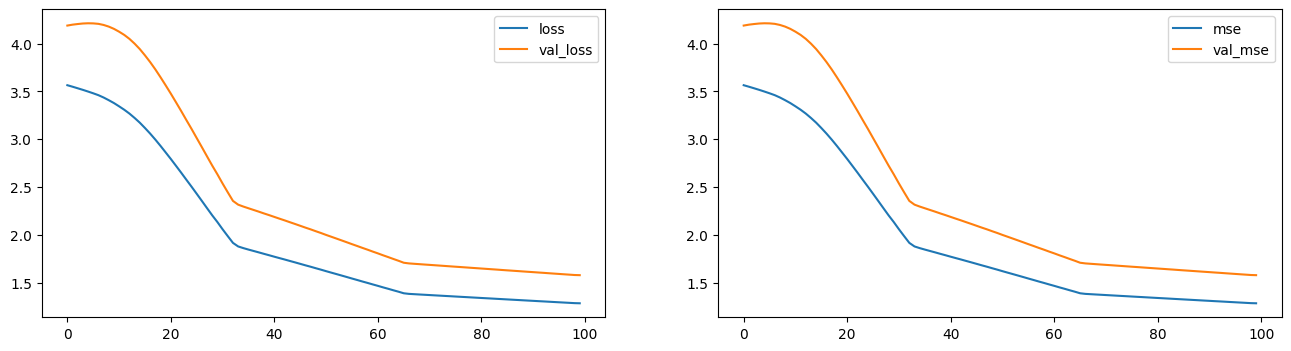

In [193]:
vis_history(mse_train_all, loss_train_all, mse_test_all, loss_test_all)

In [202]:
def custom_periodogram(X, model):
    if type(X).__name__ == 'ndarray':
        A = torch.tensor(X.copy(), dtype=torch.float32)
    else:
        A = X.copy()
    dim = A.ndim
    if dim == 1:
        A = A.view(1, A.size(0)) 
    model.eval()
    ppx_decoded = model(torch.atleast_2d(A))
    if type(X).__name__ == 'ndarray':
        ans = ppx_decoded.detach().numpy()
    else:
        ans = ppx_decoded.detach()

    if dim == 1:
        return ans[0]
    else:
        return ans

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

In [204]:
rng = np.random.default_rng()
fs = 10e3
N = 1024
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += rng.normal(scale=np.sqrt(noise_power), size=time.shape)

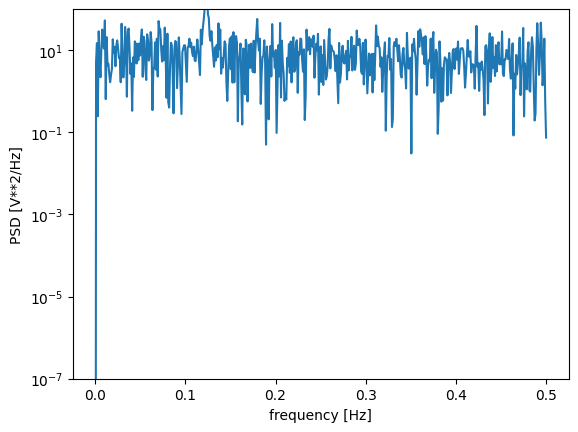

In [209]:
f, Pxx_den = signal.periodogram(x)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

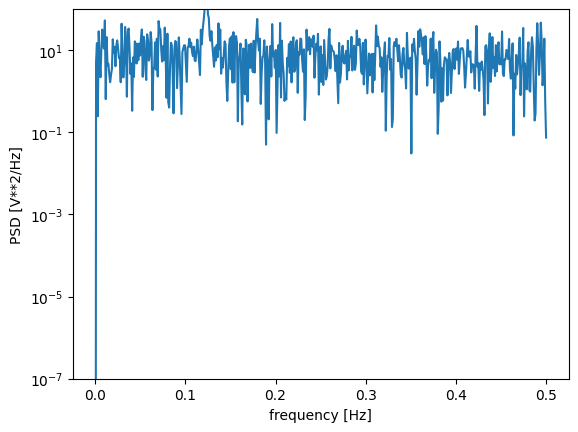

In [208]:
Pxx_den_c = custom_periodogram(x, model_p)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()